<a href="https://colab.research.google.com/github/vhrique/anne_ptbr/blob/main/05c_Aprendizagem_Nao_Supervisionada.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Aprendizagem Não-supervisionada em Redes Neurais

A aprendizagem não supervisionada busca extrair estruturas, representações ou distribuições subjacentes dos dados sem o uso de rótulos explícitos. Nessa abordagem, a rede é treinada para reconstruir, agrupar ou gerar dados de forma coerente com o conjunto original.
Entre as principais arquiteturas, destacam-se os Autoencoders (AEs), que aprendem uma representação compacta dos dados por meio da reconstrução do sinal de entrada. Variantes probabilísticas, como os Variational Autoencoders (VAEs), introduzem uma formulação bayesiana ao espaço latente, permitindo amostrar novas instâncias de forma controlada.
Outra classe relevante são os Modelos Generativos, cujo objetivo é modelar explicitamente a distribuição de probabilidade dos dados e gerar novas amostras realistas. As Generative Adversarial Networks (GANs) alcançam isso por meio de um jogo competitivo entre duas redes — o gerador, responsável por criar amostras sintéticas, e o discriminador, encarregado de distinguir entre amostras reais e falsas.

## Autoencoders

Autoencoders são modelos projetados para aprender representações dos dados ao tentar reconstruir a entrada original a partir de uma codificação latente. Eles funcionam sem a necessidade de rótulos, utilizando a própria estrutura dos dados como supervisão, tornando-os extremamente úteis para tarefas como compressão, remoção de ruído e geração de dados. Estes modelos foram introduzidos bem antes da definição formal de self-supervised learning, mas seu princípio de utilizar os próprios dados como supervisão se alinha perfeitamente com esse paradigma.


### Autoencoder Clássico

Os autoencoders são um tipo de rede neural projetada para aprender uma representação compacta dos dados, também conhecida como codificação latente, de forma não supervisionada. Uma das suas primeiras idéias surgiu na década de 1980 por Geoffrey Hinton. Eles são compostos por duas partes principais: o codificador, que reduz a dimensionalidade dos dados de entrada ao projetá-los em um espaço latente de menor dimensão, e o decodificador, que tenta reconstruir os dados originais a partir dessa representação comprimida. A principal aplicação dos autoencoders está em tarefas como redução de dimensionalidade, remoção de ruído e geração de novas amostras.

<center><img src="https://github.com/vhrique/anne_ptbr/blob/main/figures/ae.jpg?raw=true" width=500></center>

A avaliação de autoencoders geralmente é feita comparando a similaridade entre os dados de entrada e sua reconstrução gerada pelo decodificador, utilizando métricas como erro quadrático médio (MSE) ou entropia cruzada, dependendo do tipo de dados. O objetivo é minimizar essa diferença, o que indica que o autoencoder aprendeu uma boa representação latente. A otimização dos autoencoders é realizada através de técnicas padrão de redes neurais, como a _backpropagation_ e o uso de algoritmos de otimização, como o gradiente descendente e suas variantes.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

In [ ]:
class Autoencoder(nn.Module):
    def __init__(self, input_size):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_size, 256),
            nn.ReLU(),
            nn.Linear(256, 64),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(64, 256),
            nn.ReLU(),
            nn.Linear(256, input_size)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

### Variantes de Autoencoder

Entre as variações dos autoencoders, o **Denoising Autoencoder** merece destaque por sua capacidade de aprender representações robustas ao ruído. Diferente do autoencoder tradicional, ele é treinado para reconstruir a versão original de uma entrada corrompida, o que o torna ideal para tarefas de remoção de ruído e aprendizado de características mais estáveis dos dados (Vincent et al., 2008).

Outro tipo importante é o **Stacked Autoencoder**, que consiste em uma rede mais profunda, onde várias camadas de autoencoders são empilhadas (Hinton & Salakhutdinov, 2006). Isso permite que o modelo aprenda representações hierárquicas, capturando características de baixo e alto nível dos dados. Ao empilhar múltiplos autoencoders, o modelo pode capturar padrões mais complexos e abstrações, sendo amplamente utilizado em pré-treinamento de redes neurais profundas.

## Variational Autoencoders

Os autoencoders variacionais (VAEs) são uma extensão dos autoencoders tradicionais que introduzem uma abordagem probabilística para a geração de dados (Kingma e Welling, 2013). Em vez de codificar os dados diretamente em um espaço latente fixo, os VAEs aprendem distribuições probabilísticas que representam as características latentes dos dados, com a rede aprendendo os parâmetros de média e variância dessas distribuições. Essa estrutura permite que o modelo gere novas amostras ao amostrar dessas distribuições latentes, o que torna os VAEs ideais para tarefas como síntese de dados, geração de imagens e aprendizado de características latentes com maior capacidade de generalização.

<center><img src="https://github.com/vhrique/anne_ptbr/blob/main/figures/vae.jpg?raw=true" width=600></center>

Em termos de avaliação e otimização, além da reconstrução dos dados, o VAE incorpora na função de perda um termo de regularização chamado divergência Kullback-Leibler (KL), que mede o quão próxima a distribuição latente aprendida está de uma distribuição normal padrão. A otimização, então, busca equilibrar dois objetivos: minimizar a perda de reconstrução, para garantir que a entrada seja bem reconstruída, e minimizar a divergência KL, para manter a estrutura latente bem regularizada. Esse processo permite que o VAE não apenas reconstrua os dados, mas também gere novas amostras de maneira mais controlada e com maior capacidade de generalização.

In [ ]:
class VAE(nn.Module):
    def __init__(self, input_size):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_size, 400),
            nn.ReLU()
        )
        self.mu_layer = nn.Linear(400, 20)
        self.logvar_layer = nn.Linear(400, 20)  # Log variância

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(20, 400),
            nn.ReLU(),
            nn.Linear(400, input_size),
            nn.Tanh()
        )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        encoded = self.encoder(x)
        mu = self.mu_layer(encoded)
        logvar = self.logvar_layer(encoded)
        z = self.reparameterize(mu, logvar)
        decoded = self.decoder(z)
        return decoded, mu, logvar

def loss_function(recon_x, x, mu, logvar):
    BCE = nn.functional.binary_cross_entropy(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) # KL Diverg.
    return BCE + KLD

## Generative Adversarial Networks

As GANs consistem em duas redes neurais que competem entre si: uma geradora, que cria dados falsos a partir de ruído, e uma discriminadora, que tenta distinguir entre dados reais e gerados. Embora as GANs não se encaixem diretamente nas típicas tarefas de pretexto que veremos em uma seção futura, elas utilizam o aprendizado auto-supervisionado na medida em que a rede discriminadora não precisa de rótulos explícitos; ela aprende a identificar padrões nos dados gerados e reais através da própria estrutura dos dados. Este processo adversarial resulta em um modelo capaz de aprender representações poderosas sem supervisão explícita, o que torna as GANs uma ferramenta essencial para tarefas como geração de imagens, aumento de dados e transferência de estilo.

### GAN Clássico

As Generative Adversarial Networks (GANs), introduzidas por Ian Goodfellow em 2014, são um tipo de rede neural composta por dois modelos que competem entre si: um gerador, que cria novos dados a partir de uma entrada aleatória, e um discriminador, que tenta distinguir entre os dados reais e os gerados. O gerador busca melhorar suas amostras de forma a "enganar" o discriminador, enquanto o discriminador tenta identificar corretamente os dados gerados. Esse processo adversarial resulta em um gerador capaz de produzir dados realistas, como imagens, vídeos, ou textos, que são quase indistinguíveis dos dados reais. GANs têm aplicações amplas em áreas como geração de imagens, super-resolução, e síntese de dados.

<center><img src="https://github.com/vhrique/anne_ptbr/blob/main/figures/gan.jpg?raw=true" width=600></center>

In [ ]:
class Generator(nn.Module):
    def __init__(self, latent_dim, output_size):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.ReLU(),
            nn.Linear(256, output_size),
            nn.Tanh()  # Para normalizar a saída entre [0, 1]
        )

    def forward(self, z):
        img = self.model(z)
        return img

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, input_size):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        validity = self.model(x)
        return validity

### StyleGAN

A arquitetura do StyleGAN é uma evolução das redes generativas adversárias (GANs), projetada para permitir controle preciso sobre os atributos de imagens geradas. Diferente das GANs tradicionais, o StyleGAN introduz um mapeamento de espaço latente separado, onde um vetor de entrada passa por várias camadas completamente conectadas antes de ser injetado, em diferentes estágios, na rede geradora. Esse mapeamento, chamado de "style space", permite que a rede controle aspectos específicos da imagem, como cor, textura ou formato, em múltiplas escalas. A rede geradora também utiliza Adaptive Instance Normalization (AdaIN), que ajusta a ativação em cada nível da rede, permitindo variações finas nos detalhes da imagem. Essa abordagem resulta em imagens altamente realistas e oferece controle sobre características específicas, como pose ou identidade em imagens de rostos, o que torna o StyleGAN um dos modelos mais avançados para a síntese de imagens realistas.

<center><img src="https://github.com/vhrique/anne_ptbr/blob/main/figures/stylegan.JPG?raw=true" width=500></center>

### CycleGAN

O CycleGAN é uma arquitetura de rede neural voltada para a tradução de imagens entre domínios sem a necessidade de pares de imagens correspondentes no treinamento. Diferente de outras GANs, que requerem dados emparelhados (como uma imagem de entrada e sua versão modificada), o CycleGAN utiliza um ciclo de consistência para garantir que uma imagem convertida de um domínio possa ser revertida para sua forma original. Isso é feito com duas redes geradoras e duas redes discriminadoras: uma geradora transforma imagens de um domínio para outro (por exemplo, fotos para pinturas) e a segunda faz a transformação inversa. O ciclo de consistência, onde uma imagem transformada retorna ao seu estado original, ajuda a manter a estrutura da imagem. O CycleGAN é amplamente utilizado para tarefas como transferência de estilo, mudanças sazonais em fotos e modificação de imagens sem a necessidade de grandes conjuntos de dados anotados.

<center><img src="https://github.com/vhrique/anne_ptbr/blob/main/figures/cyclegan.JPG?raw=true" width=700></center>



## Modelos Generativos Recentes

Mais recentemente, os Modelos de Difusão ganharam destaque por gerar dados de alta fidelidade através de um processo progressivo de ruído e denoising, aproximando distribuições complexas. Já os Normalizing Flows oferecem uma abordagem baseada em transformações invertíveis, permitindo modelar distribuições arbitrárias de forma exata e eficiente. Esses diferentes paradigmas representam avanços complementares na busca por modelos capazes de compreender e sintetizar dados de maneira expressiva e flexível.

## Exemplo: Reconstrução e Geração de Dados com MNIST

In [ ]:
import matplotlib.pyplot as plt

from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [ ]:
batch_size = 128
latent_dim = 20
lr = 0.0004
epochs = 20

100%|██████████| 9.91M/9.91M [00:00<00:00, 20.6MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 493kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.54MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 12.9MB/s]


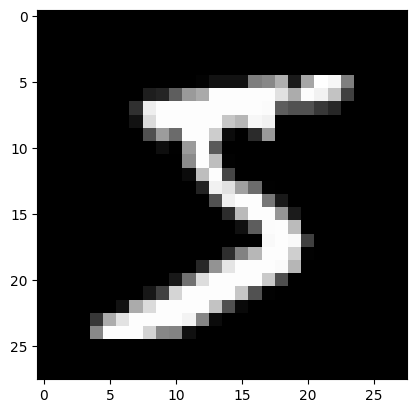

In [ ]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

plt.imshow(dataset[0][0][0], cmap='gray')
plt.show()

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Epoch [1/10], Loss: 0.1065
Epoch [2/10], Loss: 0.0761
Epoch [3/10], Loss: 0.0650
Epoch [4/10], Loss: 0.0538
Epoch [5/10], Loss: 0.0553
Epoch [6/10], Loss: 0.0566
Epoch [7/10], Loss: 0.0484
Epoch [8/10], Loss: 0.0516
Epoch [9/10], Loss: 0.0511
Epoch [10/10], Loss: 0.0490


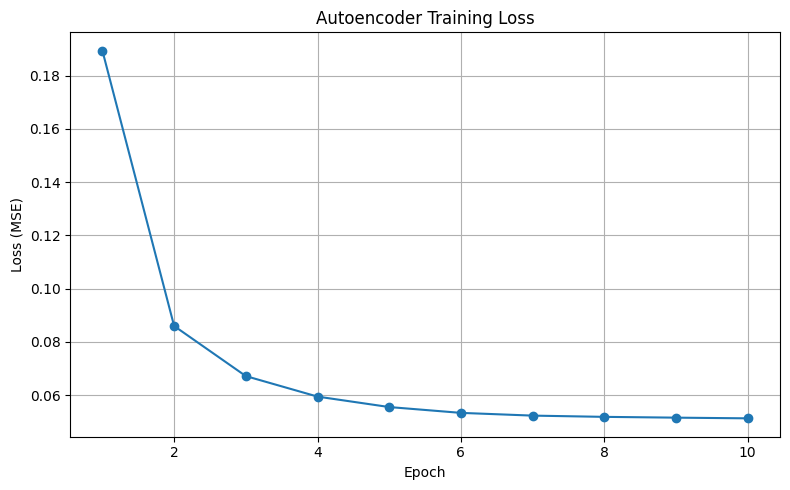

In [ ]:
ae = Autoencoder(input_size=28*28).to(device)
optimizer = optim.Adam(ae.parameters(), lr=1e-4)
criterion = nn.MSELoss()

epoch_losses = []
for epoch in range(epochs):
    running_loss = 0.0
    for imgs, _ in dataloader:
        imgs = imgs.view(imgs.size(0), -1)
        imgs = imgs.to(device)
        recon = ae(imgs)
        loss = criterion(recon, imgs)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * imgs.size(0)

    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_losses.append(epoch_loss)

    print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

plt.figure(figsize=(8, 5))
plt.plot(range(1, len(epoch_losses) + 1), epoch_losses, marker='o')
plt.title('Autoencoder Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.grid(True)
plt.tight_layout()
plt.show()

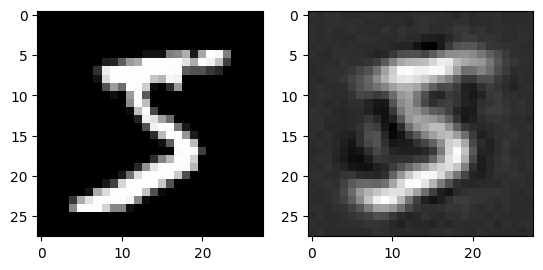

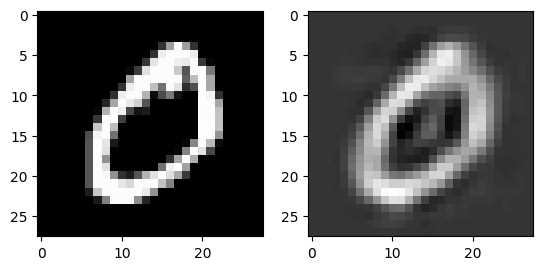

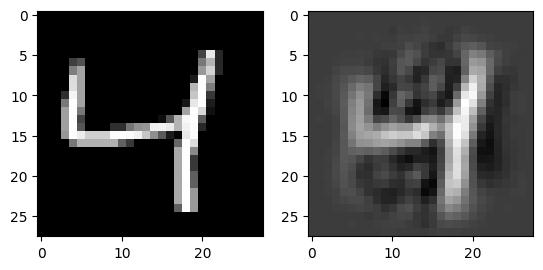

In [ ]:
for i in range(3):
    fig, axs = plt.subplots(1,2)
    output = ae(dataset[i][0].flatten().to(device))
    axs[0].imshow(dataset[i][0][0].numpy(), cmap='gray')
    axs[1].imshow(output.view(28, 28).detach().cpu().numpy(), cmap='gray')
    plt.show()

In [ ]:
import numpy as np
import umap

In [ ]:
ae.eval()
embeddings = []
labels = []

with torch.no_grad():
    for imgs, lbls in dataloader:
        imgs = imgs.to(device).view(imgs.size(0), -1)
        z = ae.encoder(imgs)  # <-- ensure your AE has an encoder module
        embeddings.append(z.cpu())
        labels.append(lbls)

embeddings = torch.cat(embeddings).numpy()
labels = torch.cat(labels).numpy()

In [ ]:
reducer = umap.UMAP(n_components=2, n_neighbors=15, min_dist=0.1)
X_2d = reducer.fit_transform(embeddings)

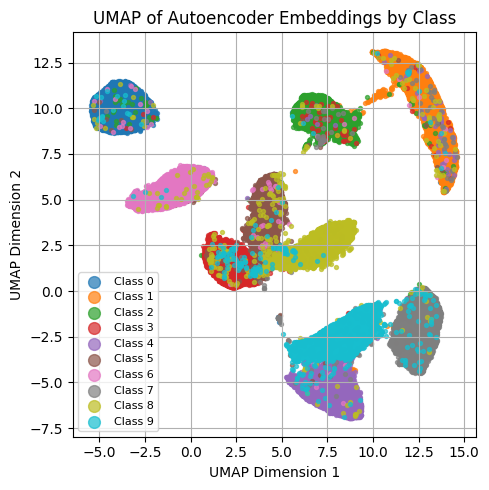

In [ ]:
plt.figure(figsize=(5, 5))
num_classes = len(np.unique(labels))
for i in range(num_classes):
    idx = labels == i
    plt.scatter(X_2d[idx, 0], X_2d[idx, 1], s=8, alpha=0.7, label=f'Class {i}')

plt.title("UMAP of Autoencoder Embeddings by Class")
plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")
plt.legend(markerscale=3, fontsize=8)
plt.grid(True)
plt.tight_layout()
plt.show()

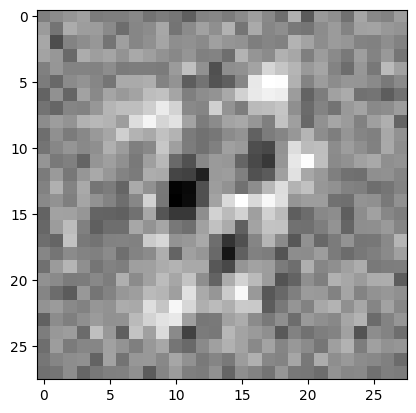

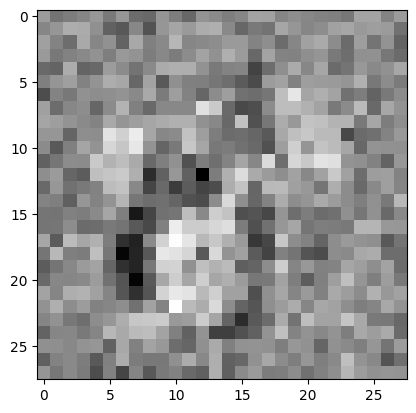

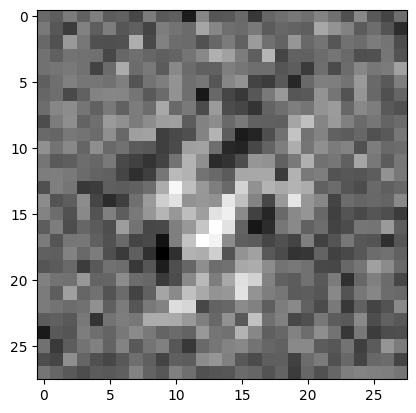

In [ ]:
for i in range(3):
    output = ae.decoder(torch.randn(1,64).to(device))[0]
    plt.imshow(output.view(28, 28).detach().cpu().numpy(), cmap='gray')
    plt.show()

Epoch [1/20], Loss: 20.0545
Epoch [2/20], Loss: 18.0081
Epoch [3/20], Loss: 17.6538
Epoch [4/20], Loss: 17.4980
Epoch [5/20], Loss: 17.3836
Epoch [6/20], Loss: 17.3433
Epoch [7/20], Loss: 17.2854
Epoch [8/20], Loss: 17.2323
Epoch [9/20], Loss: 17.2196
Epoch [10/20], Loss: 17.1907
Epoch [11/20], Loss: 17.1838
Epoch [12/20], Loss: 17.1444
Epoch [13/20], Loss: 17.1353
Epoch [14/20], Loss: 17.1352
Epoch [15/20], Loss: 17.1153
Epoch [16/20], Loss: 17.1117
Epoch [17/20], Loss: 17.1058
Epoch [18/20], Loss: 17.0990
Epoch [19/20], Loss: 17.0805
Epoch [20/20], Loss: 17.0736


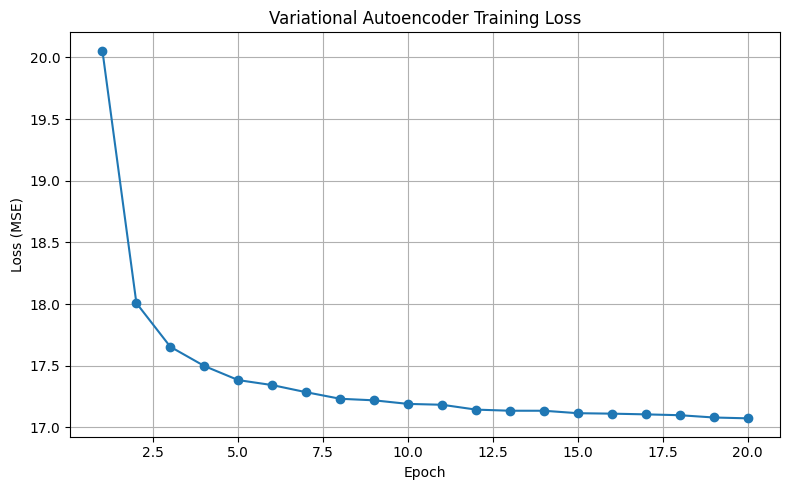

In [ ]:
vae = VAE(input_size=28*28).to(device)
optimizer = optim.Adam(vae.parameters(), lr=0.002)

def vae_loss(recon_x, x, mu, logvar, beta=10.0):
    recon_loss = nn.functional.mse_loss(recon_x, x, reduction='sum')
    kld = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return ((1.0/beta)*recon_loss + kld)/ x.size(0)

epoch_losses = []
for epoch in range(epochs):
    running_loss = 0.0
    for imgs, _ in dataloader:
        imgs = imgs.view(imgs.size(0), -1)  # Flatten the image
        imgs = imgs.to(device)
        recon, mu, logvar = vae(imgs)
        loss = vae_loss(recon, imgs, mu, logvar)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * imgs.size(0)

    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_losses.append(epoch_loss)

    print(f'Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss:.4f}')

plt.figure(figsize=(8, 5))
plt.plot(range(1, len(epoch_losses) + 1), epoch_losses, marker='o')
plt.title('Variational Autoencoder Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.grid(True)
plt.tight_layout()
plt.show()

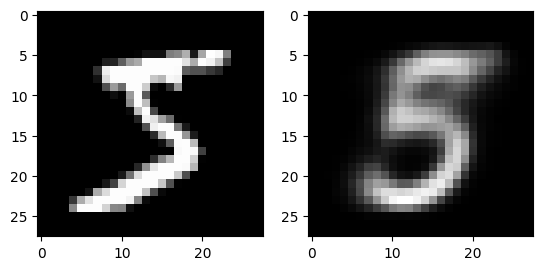

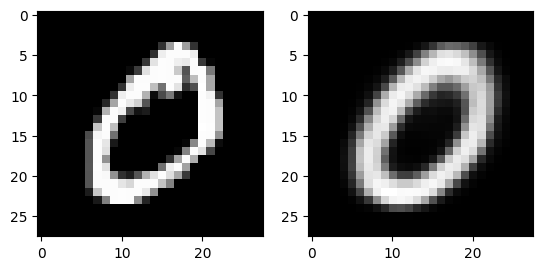

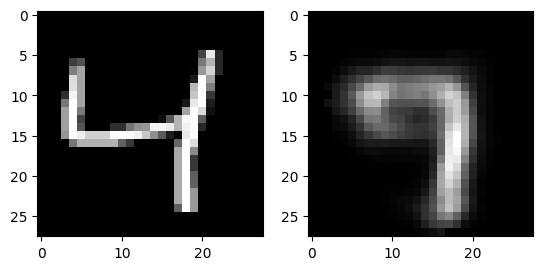

In [ ]:
for i in range(3):
    fig, axs = plt.subplots(1,2)
    output = vae(dataset[i][0].flatten().to(device))[0]
    axs[0].imshow(dataset[i][0][0].numpy(), cmap='gray')
    axs[1].imshow(output.view(28, 28).detach().cpu().numpy(), cmap='gray')
    plt.show()

In [ ]:
vae.eval()
embeddings = []
labels = []

with torch.no_grad():
    for imgs, lbls in dataloader:
        imgs = imgs.to(device).view(imgs.size(0), -1)
        z = vae.encoder(imgs)  # <-- ensure your AE has an encoder module
        embeddings.append(z.cpu())
        labels.append(lbls)

embeddings = torch.cat(embeddings).numpy()
labels = torch.cat(labels).numpy()

In [ ]:
reducer = umap.UMAP(n_components=2, n_neighbors=15, min_dist=0.1)
X_2d = reducer.fit_transform(embeddings)

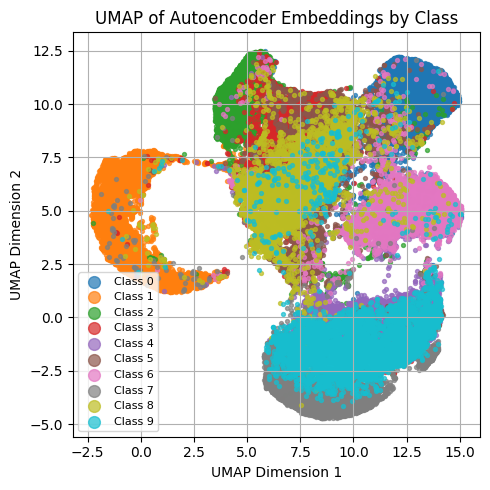

In [ ]:
plt.figure(figsize=(5, 5))
num_classes = len(np.unique(labels))
for i in range(num_classes):
    idx = labels == i
    plt.scatter(X_2d[idx, 0], X_2d[idx, 1], s=8, alpha=0.7, label=f'Class {i}')

plt.title("UMAP of Autoencoder Embeddings by Class")
plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")
plt.legend(markerscale=3, fontsize=8)
plt.grid(True)
plt.tight_layout()
plt.show()

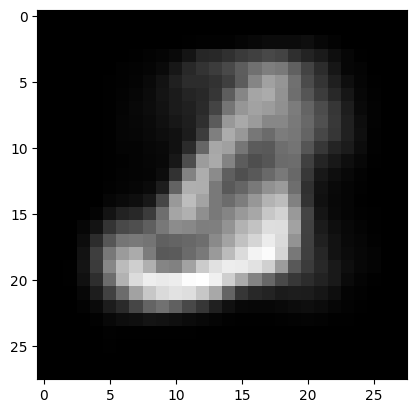

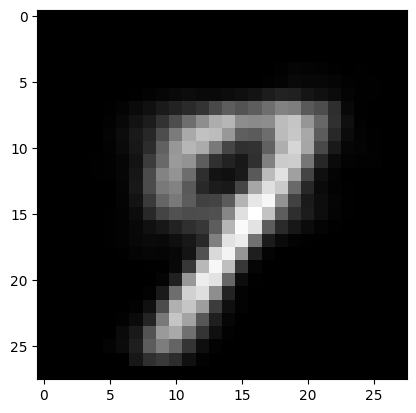

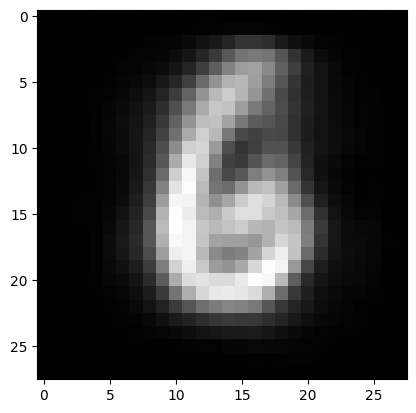

In [ ]:
for i in range(3):
    output = vae.decoder(torch.randn(1,20).to(device))[0]
    plt.imshow(output.view(28, 28).detach().cpu().numpy(), cmap='gray')
    plt.show()

--> Epoch [1/40] Loss_D: 0.5118, Loss_G: 2.2983
--> Epoch [2/40] Loss_D: 0.5935, Loss_G: 2.5447
--> Epoch [3/40] Loss_D: 0.3886, Loss_G: 3.3814
--> Epoch [4/40] Loss_D: 0.6161, Loss_G: 2.9380
--> Epoch [5/40] Loss_D: 0.6427, Loss_G: 2.6950
--> Epoch [6/40] Loss_D: 0.8336, Loss_G: 2.4318
--> Epoch [7/40] Loss_D: 0.9786, Loss_G: 2.3920
--> Epoch [8/40] Loss_D: 0.9723, Loss_G: 1.9401
--> Epoch [9/40] Loss_D: 1.1853, Loss_G: 1.7723
--> Epoch [10/40] Loss_D: 1.0150, Loss_G: 1.9408


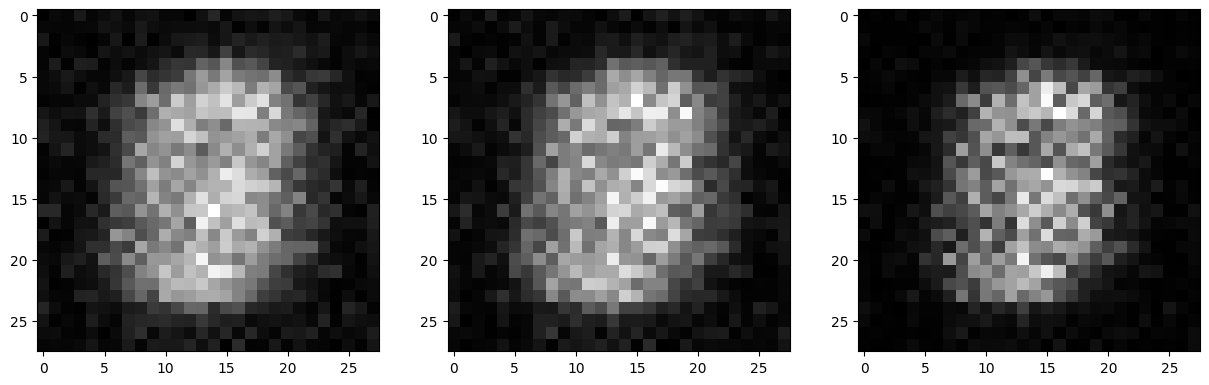

--> Epoch [11/40] Loss_D: 1.4201, Loss_G: 1.5493
--> Epoch [12/40] Loss_D: 1.0562, Loss_G: 1.9894
--> Epoch [13/40] Loss_D: 1.2484, Loss_G: 1.4345
--> Epoch [14/40] Loss_D: 1.2512, Loss_G: 1.5485
--> Epoch [15/40] Loss_D: 1.0582, Loss_G: 2.0778
--> Epoch [16/40] Loss_D: 1.1411, Loss_G: 1.7505
--> Epoch [17/40] Loss_D: 1.0954, Loss_G: 1.6056
--> Epoch [18/40] Loss_D: 1.1821, Loss_G: 1.7906
--> Epoch [19/40] Loss_D: 1.2970, Loss_G: 1.3638
--> Epoch [20/40] Loss_D: 1.3814, Loss_G: 1.2291


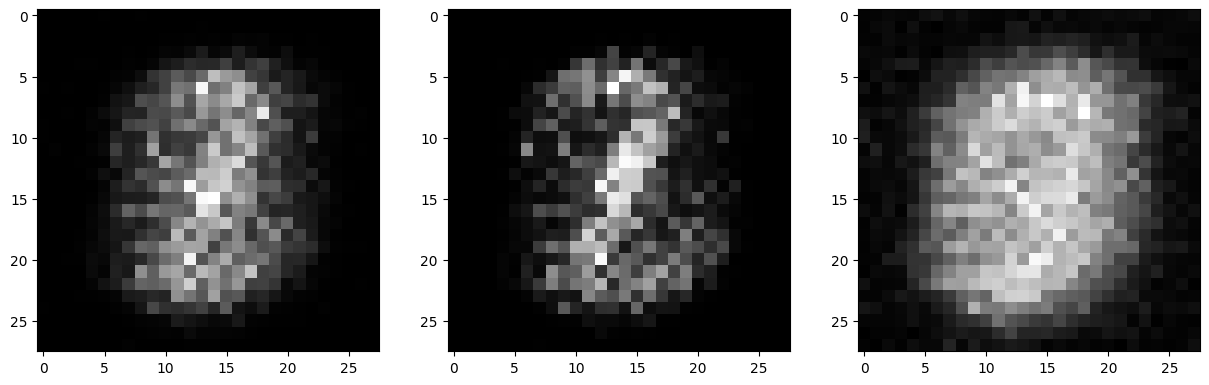

--> Epoch [21/40] Loss_D: 1.0101, Loss_G: 1.7158
--> Epoch [22/40] Loss_D: 1.0269, Loss_G: 1.6865
--> Epoch [23/40] Loss_D: 0.7371, Loss_G: 2.4098
--> Epoch [24/40] Loss_D: 0.8632, Loss_G: 2.1973
--> Epoch [25/40] Loss_D: 1.0153, Loss_G: 2.2559
--> Epoch [26/40] Loss_D: 1.1037, Loss_G: 2.1436
--> Epoch [27/40] Loss_D: 0.9328, Loss_G: 1.9759
--> Epoch [28/40] Loss_D: 0.8621, Loss_G: 1.8483
--> Epoch [29/40] Loss_D: 0.8848, Loss_G: 2.2522
--> Epoch [30/40] Loss_D: 0.8502, Loss_G: 2.5140


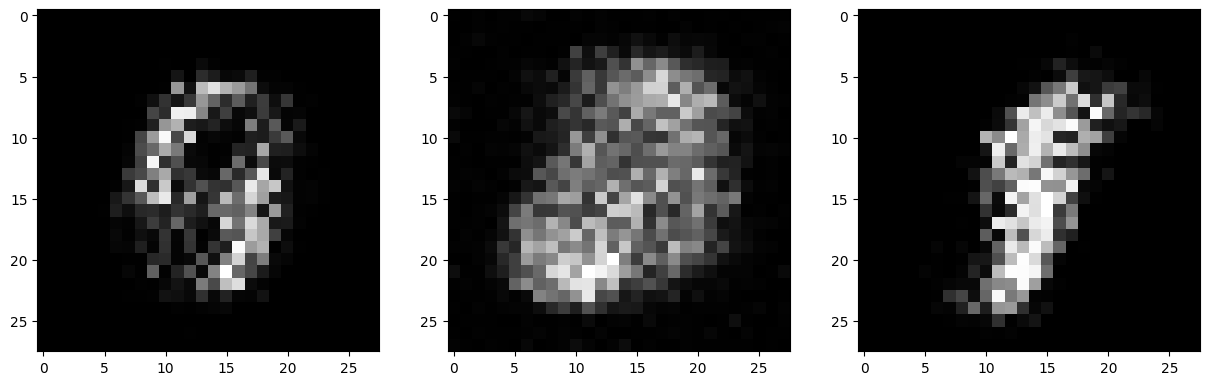

--> Epoch [31/40] Loss_D: 1.0560, Loss_G: 2.1158
--> Epoch [32/40] Loss_D: 1.0984, Loss_G: 2.1625
--> Epoch [33/40] Loss_D: 1.0325, Loss_G: 2.1657
--> Epoch [34/40] Loss_D: 0.8566, Loss_G: 2.4291
--> Epoch [35/40] Loss_D: 0.9948, Loss_G: 2.3148
--> Epoch [36/40] Loss_D: 0.9978, Loss_G: 2.0018
--> Epoch [37/40] Loss_D: 0.9024, Loss_G: 2.3832
--> Epoch [38/40] Loss_D: 1.0282, Loss_G: 2.3556
--> Epoch [39/40] Loss_D: 1.1621, Loss_G: 2.1363
--> Epoch [40/40] Loss_D: 0.9840, Loss_G: 2.3501


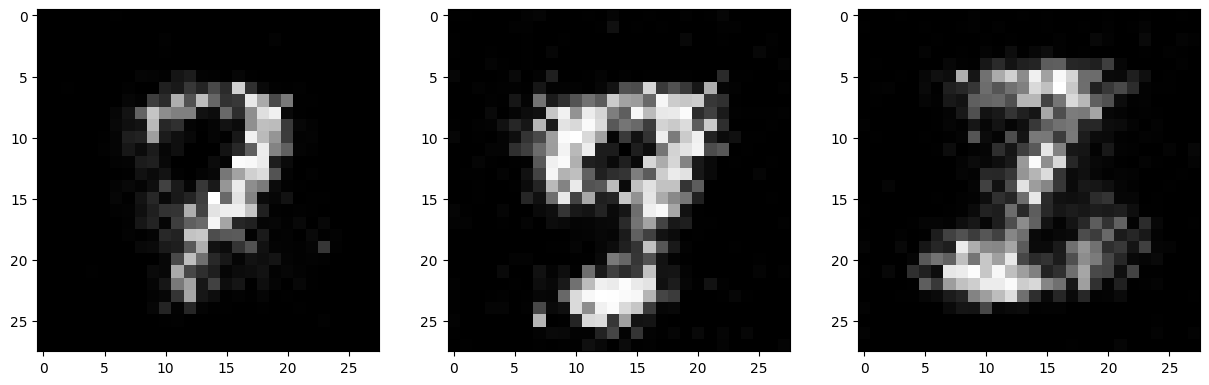

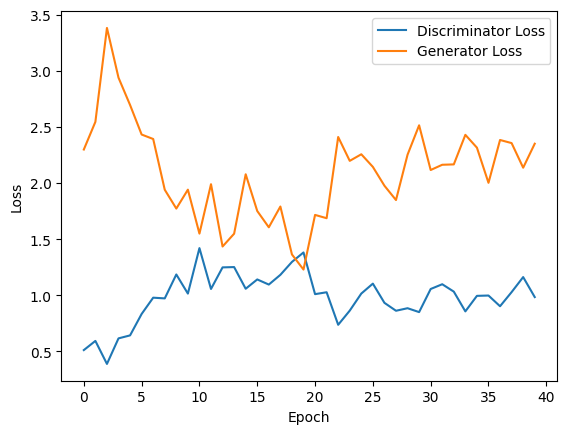

In [ ]:
generator = Generator(latent_dim, 28*28)
discriminator = Discriminator(28*28)
adversarial_loss = nn.BCELoss()

optimizer_G = optim.Adam(generator.parameters(), lr=0.0005)
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0005)

g_losses = []
d_losses = []

epochs = 40

for epoch in range(epochs):

    running_g_loss = 0.0
    running_d_loss = 0.0

    for i, (imgs, _) in enumerate(dataloader):
        # Ground truths
        real_imgs = imgs
        real_labels = torch.ones(imgs.size(0), 1)
        fake_labels = torch.zeros(imgs.size(0), 1)

        # ---------------------
        # Train Discriminator
        # ---------------------
        optimizer_D.zero_grad()

        # Real images
        real_loss = adversarial_loss(discriminator(real_imgs.view(real_imgs.size(0), -1)), real_labels)

        # Fake images
        z = torch.randn(imgs.size(0), latent_dim)
        fake_imgs = generator(z)
        fake_loss = adversarial_loss(discriminator(fake_imgs.detach()), fake_labels)

        d_loss = real_loss + fake_loss
        d_loss.backward()
        optimizer_D.step()

        # -----------------
        # Train Generator
        # -----------------
        optimizer_G.zero_grad()

        # Train the generator to "fool" the discriminator
        g_loss = adversarial_loss(discriminator(fake_imgs), real_labels)
        g_loss.backward()
        optimizer_G.step()

        running_d_loss += d_loss.item()
        running_g_loss += g_loss.item()

    epoch_d_loss = running_d_loss / len(dataloader)
    epoch_g_loss = running_g_loss / len(dataloader)

    d_losses.append(epoch_d_loss)
    g_losses.append(epoch_g_loss)

    print(f'--> Epoch [{epoch+1}/{epochs}] Loss_D: {epoch_d_loss:.4f}, Loss_G: {epoch_g_loss:.4f}')
    if epoch % 10 == 9:
        fig, axs = plt.subplots(1,3,figsize=(15,5))
        for f in range(3):
            axs[f].imshow(fake_imgs[f].view(28, 28).detach().cpu().numpy(), cmap='grey')
        plt.show()

plt.plot(d_losses, label='Discriminator Loss')
plt.plot(g_losses, label='Generator Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Exercício

1. Compare a interpolação de amostras entre Autoencoder e Variational Autoencoder.

    a. Pegue duas amostras reais de classes similares (4 e 9, ou 5 e 3)
    
    b. Extraia seus valores no espaço latente com o encoder.
    c. Gere 5 amostras no espaço latente, que são a interpolação entre as duas amostras.

    d. Utilize o decoder para gerar as 5 imagens interpoladas.
    
    e. Discuta a diferença entre o Autoencoder e o Variational Autoencoder.

# Considerações Finais

Neste capítulo, abordamos modelos não-supervisionados de redes neurais artificiais. Ao invés de utilizar dados anotados, modelamos os dados para aprender representações latentes e/ou gerar amostras novas.

## Próximos Capítulos

Nos próximos capítulos, continuaremos vendo paradigmas avançados de aprendizagem, como:

- Multi-task Learning
- Multi-modal Learning
- Joint Embedding

# Referências

- Rumelhart, D. E., Hinton, G. E., & Williams, R. J. (1986). Learning internal representations by error propagation. Parallel distributed processing, explorations in the microstructure of cognition.
- Vincent, P., Larochelle, H., Bengio, Y., & Manzagol, P. A. (2008, July). Extracting and composing robust features with denoising autoencoders. In Proceedings of the 25th international conference on Machine learning (pp. 1096-1103).
- Hinton, G. E., & Salakhutdinov, R. R. (2006). Reducing the dimensionality of data with neural networks. science, 313(5786), 504-507.
- Kingma, D. P. (2013). Auto-encoding variational bayes. arXiv preprint arXiv:1312.6114.
- Goodfellow, I., Pouget-Abadie, J., Mirza, M., Xu, B., Warde-Farley, D., Ozair, S., ... & Bengio, Y. (2014). Generative adversarial nets. Advances in neural information processing systems, 27.
- Karras, T., Laine, S., & Aila, T. (2019). A style-based generator architecture for generative adversarial networks. In Proceedings of the IEEE/CVF conference on computer vision and pattern recognition (pp. 4401-4410).
- Zhu, J. Y., Park, T., Isola, P., & Efros, A. A. (2017). Unpaired image-to-image translation using cycle-consistent adversarial networks. In Proceedings of the IEEE international conference on computer vision (pp. 2223-2232).